In [62]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis

In [63]:
movies = pd.read_csv('../data/raw/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [64]:
movies.shape

(27278, 3)

In [65]:
gscores = pd.read_csv('../data/raw/genome-scores.csv')
gscores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [66]:
gtags = pd.read_csv('../data/raw/genome-tags.csv')
gtags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [67]:
gtags.shape

(1128, 2)

In [68]:
links = pd.read_csv('../data/raw/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [69]:
ratings = pd.read_csv('../data/raw/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64


<Axes: xlabel='rating', ylabel='Count'>

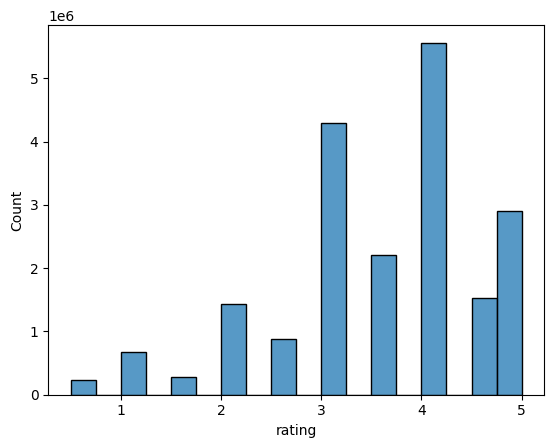

In [79]:
# Les ratings sont très largement skewed-right (bcp plus de ratings élevés - 4, 4.5, 5 - que de ratings faibles - 1, 1.5, 2)
print(ratings['rating'].value_counts())
sns.histplot(ratings, x='rating', binwidth=0.25)

In [78]:
# Les ratings vont de 0.5 à 5
print(ratings['rating'].min())
print(ratings['rating'].max())


rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64
0.5
5.0


In [81]:
# Les films présents dans la BDD vont de 1995 à 2015
print(datetime.fromtimestamp(ratings['timestamp'].min()))
print(datetime.fromtimestamp(ratings['timestamp'].max()))

1995-01-09 12:46:44
2015-03-31 08:40:02


# Retro Engineering Fonctionnement User Matrix - Modèle de Base

In [72]:
user_matrix = pd.read_csv('../data/processed/user_matrix.csv')
user_matrix.head()

,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.0,0.129412,0.123529,0.029412,0.082353,0.352941,0.141176,0.029412,0.505882,...,0.017647,0.076471,0.005882,0.041176,0.047059,0.205882,0.076471,0.182353,0.041176,0.023529
1,2,0.0,0.083333,0.100000,0.033333,0.066667,0.383333,0.033333,0.033333,0.483333,...,0.016667,0.116667,0.000000,0.066667,0.050000,0.233333,0.083333,0.233333,0.050000,0.016667
2,3,0.0,0.127072,0.088398,0.022099,0.055249,0.298343,0.071823,0.027624,0.475138,...,0.027624,0.116022,0.000000,0.038674,0.044199,0.132597,0.116022,0.176796,0.049724,0.011050
3,4,0.0,0.178571,0.142857,0.071429,0.071429,0.357143,0.035714,0.035714,0.571429,...,0.000000,0.035714,0.035714,0.107143,0.071429,0.107143,0.000000,0.178571,0.035714,0.107143
4,5,0.0,0.142857,0.095238,0.079365,0.126984,0.380952,0.015873,0.063492,0.555556,...,0.000000,0.047619,0.015873,0.079365,0.063492,0.142857,0.031746,0.238095,0.031746,0.015873


In [73]:
# Split the 'genres' column into individual genres
genres = movies["genres"].str.get_dummies(sep="|")

# Concatenate the original movieId and title columns with the binary genre columns
movies_genres = pd.concat([movies[["movieId", "title"]], genres], axis=1)
movies_genres.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
movie_ratings = ratings.merge(movies_genres, on="movieId", how="inner")
movie_ratings.head()

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,1112486027,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,1112484676,"City of Lost Children, The (CitÃ© des enfants ...",0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [75]:
# Drop useless features
movie_ratings = movie_ratings.drop(columns = ["movieId", "timestamp", "title", "rating"])
movie_ratings.head()

,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [76]:
# Calculate user_matrix
user_matrix = movie_ratings.groupby("userId").agg(
    "mean",
)

user_matrix.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.0,0.377143,0.417143,0.057143,0.108571,0.234286,0.120000,0.000000,0.245714,0.394286,0.000000,0.257143,0.011429,0.017143,0.102857,0.062857,0.228571,0.240000,0.051429,0.022857
2,0.0,0.311475,0.278689,0.016393,0.016393,0.163934,0.016393,0.000000,0.311475,0.016393,0.016393,0.295082,0.016393,0.032787,0.065574,0.098361,0.377049,0.311475,0.065574,0.032787
3,0.0,0.326203,0.267380,0.021390,0.053476,0.278075,0.112299,0.005348,0.310160,0.106952,0.005348,0.171123,0.000000,0.032086,0.058824,0.085561,0.497326,0.267380,0.032086,0.016043
4,0.0,0.464286,0.214286,0.071429,0.142857,0.392857,0.214286,0.000000,0.285714,0.107143,0.000000,0.000000,0.000000,0.071429,0.107143,0.142857,0.178571,0.464286,0.035714,0.035714
5,0.0,0.272727,0.318182,0.090909,0.166667,0.363636,0.106061,0.000000,0.409091,0.166667,0.000000,0.015152,0.045455,0.121212,0.030303,0.242424,0.151515,0.227273,0.015152,0.030303


# Tentative Collaborative Filtering

In [24]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [25]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


## Méthode 1 - Numpy Matrix

In [82]:
# Réduction mémoire dataframe
ratings['userId'] = ratings['userId'].astype(np.int32)
ratings['movieId'] = ratings['movieId'].astype(np.int32)
ratings['rating'] = ratings['rating'].astype(np.float16)

In [83]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float16
 3   timestamp  int64  
dtypes: float16(1), int32(2), int64(1)
memory usage: 343.3 MB


In [84]:
# Filtrage des films sur la base du nombre de ratings > 10000

nb_ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index().sort_values(by = 'rating', ascending = False)

print(nb_ratings_per_movie[nb_ratings_per_movie['rating'] > 10000].shape)
print(nb_ratings_per_movie.head())

(462, 2)
     movieId  rating
293      296   67310
352      356   66172
315      318   63366
587      593   63299
476      480   59715


In [85]:
movies_sup_10000_ratings = nb_ratings_per_movie[nb_ratings_per_movie['rating'] > 10000]['movieId'].to_list()
ratings_popular_movies = ratings[ratings['movieId'].isin(movies_sup_10000_ratings)].reset_index().drop(columns = 'index')
ratings_popular_movies.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,32,3.5,1112484819
2,1,47,3.5,1112484727
3,1,50,3.5,1112484580
4,1,112,3.5,1094785740


In [86]:
ratings_popular_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9050396 entries, 0 to 9050395
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float16
 3   timestamp  int64  
dtypes: float16(1), int32(2), int64(1)
memory usage: 155.4 MB


In [87]:
ratings_popular_movies.shape

(9050396, 4)

In [88]:
# Create unique indices for user and movie IDs
user_ids = np.unique(ratings_popular_movies['userId'])
movie_ids = np.unique(ratings_popular_movies['movieId'])

# Create mappings from user/movie IDs to indices
user_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Number of users and movies
num_users = len(user_ids)
num_movies = len(movie_ids)

In [89]:
print(num_movies)

462


In [90]:
# Initialize the user-item matrix with zeros
user_item_matrix = np.zeros((num_users, num_movies))

# Populate the matrix
for _, row in ratings_popular_movies.iterrows():
    user_idx = user_index[row['userId']]
    movie_idx = movie_index[row['movieId']]
    user_item_matrix[user_idx, movie_idx] = row['rating']

In [98]:
# Display part of the matrix
print(user_item_matrix[:10, :10])  # Print a small part to check


[[0.  3.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  4.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  3.  0.  4.  0.  0.  0. ]
 [0.  3.  0.  0.  0.  0.  0.  5.  0.  3. ]
 [5.  0.  3.  0.  0.  5.  0.  0.  0.  5. ]
 [0.  0.  3.  0.  0.  3.  0.  4.  3.  2. ]
 [4.  0.  5.  0.  3.  0.  4.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  0.  0.  0.  0.  0.  4.  0.  0. ]]


In [99]:
# Save the matrix
np.save('../data/processed/user_item_matrix.npy', user_item_matrix)

In [100]:
# Load the matrix
user_item_matrix = np.load('../data/processed/user_item_matrix.npy')
print(user_item_matrix.shape)

(137658, 462)


In [101]:
from sklearn.neighbors import NearestNeighbors

In [104]:
def train_model_knn(user_item_matrix, n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(user_item_matrix)
    return nbrs

In [107]:
def predict_ratings(model, n_neighbors):
    """
    Function predicts ratings for each of the top movie for the x first users based on n_neighbors defined in model training above.
    """
    predict_matrix = []

    for u in range(100):
        _, indices = model.kneighbors(user_item_matrix[u].reshape(1, -1))

        # Predicting rating for movies
        selected_rows = user_item_matrix[indices].reshape(n_neighbors, 462)
        similar_users_ratings = pd.DataFrame(selected_rows)
        similar_users_ratings = similar_users_ratings.replace(0, np.nan)

        # Calculate the mean of each column (ignoring NaNs)
        average_ratings = similar_users_ratings.mean()
        predict_matrix.append(np.array(average_ratings))

    return predict_matrix

In [108]:
n_neighbors=10

model = train_model_knn(user_item_matrix, n_neighbors=n_neighbors)
predict_matrix = predict_ratings(model, n_neighbors=n_neighbors)


### ==> Résultats : 

- Préparation de la matrice trop longue (10 min, sans doute largement optimisable)
- Prédiction des notes sur l'ensemble des users demande trop de mémoire (dans l'exemple ci-dessus, j'ai dû limiter à 100 users dans la fonction => résultat entraînement et prédiction 100 users = 33 secondes)

In [109]:
# Exemple de prédictions sur le user 0
predict_matrix[0]

array([3.5       , 3.        , 2.        ,        nan,        nan,
       0.5       ,        nan,        nan, 3.        ,        nan,
       3.        ,        nan,        nan, 3.1       ,        nan,
              nan,        nan,        nan, 3.3       ,        nan,
       3.57142857, 2.        ,        nan, 2.25      ,        nan,
       2.5       , 3.        , 3.5       , 2.125     ,        nan,
              nan, 3.5       , 3.        ,        nan,        nan,
              nan,        nan, 2.5       , 1.5       ,        nan,
       2.5       , 1.5       ,        nan,        nan,        nan,
              nan, 3.5       ,        nan,        nan, 3.        ,
              nan,        nan,        nan, 2.66666667, 3.35714286,
              nan,        nan,        nan,        nan,        nan,
              nan, 3.25      , 3.7       ,        nan,        nan,
              nan,        nan, 3.9       , 3.        ,        nan,
       3.5       ,        nan, 2.5       ,        nan,        

In [73]:
# L'idée était ensuite de comparer la user_item_matrix des ratings constatés avec la predicted_matrix pour calculer une MAE
user_item_matrix_for_mae = pd.DataFrame(user_item_matrix).replace(0, np.nan)
user_item_matrix_for_mae

,0,1,2,3,4,5,6,7,8,9,...,452,453,454,455,456,457,458,459,460,461
0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
137654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137655,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
137656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### => Abandon de ce modèle

# Méthode 2 - SVD (Singular Value Decomposition) sur CSR Matrix 

In [110]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix

In [111]:
# Example data loading
ratings = pd.read_csv('../data/raw/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [112]:
# Réduction mémoire dataframe
ratings['rating'] = ratings['rating'].astype(np.float32)

In [113]:
def reduce_user_item_matrix(ratings, min_ratings_movie, min_ratings_user):
    """ Returns a dataframe containing userId, movieId, rating, timestamp filtered on number of ratings minimum defined as parameters"""

    # Count nb_ratings per movie and keep only movies with nb_ratings > min_ratings_movie
    nb_ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index().sort_values(by = 'rating', ascending = False)
    movies_filtered = nb_ratings_per_movie[nb_ratings_per_movie['rating'] > min_ratings_movie]['movieId'].to_list()
    ratings_movies_filtered = ratings[ratings['movieId'].isin(movies_filtered)].reset_index().drop(columns = 'index')

    # Count nb_ratings per movie and keep only movies with nb_ratings > min_ratings_movie
    nb_ratings_per_user = ratings.groupby('userId')['rating'].count().reset_index()
    users_filtered = nb_ratings_per_user[nb_ratings_per_user['rating'] > min_ratings_user]['userId'].to_list()
    ratings_users_filtered = ratings_movies_filtered[ratings_movies_filtered['userId'].isin(users_filtered)].reset_index().drop(columns = 'index')

    return ratings_users_filtered

In [160]:
ratings_filtered = reduce_user_item_matrix(ratings, min_ratings_movie=10000, min_ratings_user=0)

MemoryError: Unable to allocate 153. MiB for an array with shape (20000263,) and data type int64

In [ ]:
ratings_filtered.shape

(20000263, 4)

In [ ]:
ratings_filtered['userId'].max()

138493

In [ ]:
ratings_filtered['userId'].unique()

array([     1,      2,      3, ..., 138491, 138492, 138493], dtype=int64)

In [ ]:
# Create a mapping for userId and movieId (if we don't do that, since the matrix has userId 138493, the sparse matrix contains 138493 rows)
user_id_mapping = {id: i for i, id in enumerate(ratings_filtered['userId'].unique())}
movie_id_mapping = {id: i for i, id in enumerate(ratings_filtered['movieId'].unique())}

# Use the mapping to translate the original ids to the new form
ratings_filtered['userId'] = ratings_filtered['userId'].map(user_id_mapping)
ratings_filtered['movieId'] = ratings_filtered['movieId'].map(movie_id_mapping)

In [ ]:
ratings_matrix = csr_matrix((ratings_filtered.rating, (ratings_filtered.userId, ratings_filtered.movieId)), dtype=np.float32)
dense_ratings = ratings_matrix.toarray()

In [ ]:
ratings_matrix.shape

(138493, 26744)

In [ ]:
# SVD model
svd = TruncatedSVD(n_components=50)
user_factors = svd.fit_transform(ratings_matrix)

In [ ]:
# Making predictions
predicted_ratings = svd.inverse_transform(user_factors)

MemoryError: Unable to allocate 13.8 GiB for an array with shape (138493, 26744) and data type float32

In [ ]:
predicted_ratings[:10, 0]

array([0.75433004, 0.0817732 , 1.084085  , 0.77374107, 1.1398937 ,
       0.24333996, 0.6198638 , 1.0983506 , 0.08183617, 0.15752214],
      dtype=float32)

In [ ]:
predicted_ratings.max()

9.633393

In [ ]:
# Calculate MAE
mae = mean_absolute_error(dense_ratings, predicted_ratings)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.5195568203926086


In [ ]:
user_matrix_1000 = user_matrix[:1000]
user_matrix_1000.to_csv('../tests/fixtures/user_matrix_test.csv', index = None)